 # Application of machine learning approaches towards the prediction of gene expression levels in *Streptococcus thermophilus*
Prediction of gene expression levels from promoter sequences

In [3]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import xgboost as xgboost
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

## Data arrangement and pre-processing

In [4]:
# Load the promoter sequences

filtered_promoter_file_path = r"../promoter_extraction/filtered_promoters_100_bp.fasta"

def read_filtered_promoters(file_path):
    """
    Reads the filtered promoters from a file and returns each line
    :param file_path: path to the file with the filtered promoters
    :return: lines of the file
    """
    with open(file_path, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split("\t") for line in lines]
    lines = [line[0] for line in lines]
    return lines

# read_filtered_promoters(filtered_promoter_file_path)

In [5]:
# Create a dataframe with the promoter sequences

def create_filtered_promoters_df(filename):
    """
    Creates a dataframe with the filtered promoters
    :param filename: name of the file with the filtered promoters
    :return: dataframe with the filtered promoters indicating if they correspond to the reverse complement of the gene, the locus tag of the gene and its coordiantes.
    """
    lines = read_filtered_promoters(filename)
    df = pd.DataFrame(lines)
    df.columns = ['Promoter Type']
    df[['Promoter Type', 'Locus Tag', "Location Coordinates", "Promoter Sequence"]] = df['Promoter Type'].str.split(';', 4, expand=True)
    return df

filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_promoter_df
# create_filtered_promoters_df(filtered_promoter_file_path)

Promoter Type   Locus Tag  Location Coordinates  \
0    Promoter reverse complement  T303_00015        [2011:2347](-)   
1    Promoter reverse complement  T303_00025        [4153:5353](-)   
2    Promoter reverse complement  T303_00030        [6254:7709](-)   
3    Promoter reverse complement  T303_00035        [7890:8945](-)   
4                       Promoter  T303_00050      [10422:10776](+)   
..                           ...         ...                   ...   
803                     Promoter  T303_09885  [1840783:1840921](+)   
804  Promoter reverse complement  T303_09890  [1841032:1842175](-)   
805  Promoter reverse complement  T303_09895  [1842429:1842711](-)   
806  Promoter reverse complement  T303_09900  [1843080:1843215](-)   
807                     Promoter  T303_09905  [1844132:1845461](+)   

                                     Promoter Sequence  
0    AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGG...  
1    AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTC...  
2    AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTC...  
3    TCATTGTAAGAGTAGTAAAAACCTATCTTCGGATAGGTTTTTTTAA...  
4    TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCT...  
..                                                 ...  
803  AAAACTTAAATATACAATACAAGAGATAAGTACACAATAAAAACTC...  
804  TGACAATTCTTATAAAATTTGATACACTAATGCAGTTGTGGATAAT...  
805  TGGGAAATACAAAGCAAGTATTGGTCAAATCTTCCTATTATTATGT...  
806  ACAAGAGCATGCTATTACTATAAAATAATATGGTATGTTTAGTAAC...  
807  CTTTTCATTGTCAAAAAAACTAGCCTTAAAATAAGACTAGTTTTTG...  

[808 rows x 4 columns]

In [6]:
# Create dataframe with the gene expression values

expression_data = pd.read_excel("gene_expression_dataset.XLSX", sheet_name='log2CPM_AllConditions')
expression_df = pd.DataFrame(expression_data, columns=["Locus Tag", "Gene Expression Values for Condition 1 (Mean)"])
expression_df.set_index("Locus Tag", inplace=True)
expression_df

Gene Expression Values for Condition 1 (Mean)
Locus Tag                                                
T303_00005                                       9.794827
T303_00010                                       8.822171
T303_00015                                       7.451894
T303_00020                                       7.297720
T303_00025                                       7.992131
...                                                   ...
T303_09885                                       0.355902
T303_09890                                       8.589898
T303_09895                                       1.157323
T303_09900                                      10.162983
T303_09905                                      -0.328002

[1711 rows x 1 columns]

In [7]:
# Remove the genes that were filtered in the promoter sequences

# filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_locus_tag_list = filtered_promoter_df['Locus Tag'].tolist()
# print(len(filtered_locus_tag_list))
final_expression_df = expression_df[expression_df.index.isin(filtered_locus_tag_list)]
final_expression_df

Gene Expression Values for Condition 1 (Mean)
Locus Tag                                                
T303_00015                                       7.451894
T303_00025                                       7.992131
T303_00030                                       9.886140
T303_00050                                       6.207110
T303_00075                                       6.291600
...                                                   ...
T303_09885                                       0.355902
T303_09890                                       8.589898
T303_09895                                       1.157323
T303_09900                                      10.162983
T303_09905                                      -0.328002

[694 rows x 1 columns]

In [8]:
# Remove the promoter sequences that were not found in the expression data

filtered_expression_genes_List = final_expression_df.index.tolist()
final_promoter_df = filtered_promoter_df[filtered_promoter_df["Locus Tag"].isin(filtered_expression_genes_List)]
final_promoter_df

Promoter Type   Locus Tag  Location Coordinates  \
0    Promoter reverse complement  T303_00015        [2011:2347](-)   
1    Promoter reverse complement  T303_00025        [4153:5353](-)   
2    Promoter reverse complement  T303_00030        [6254:7709](-)   
4                       Promoter  T303_00050      [10422:10776](+)   
6    Promoter reverse complement  T303_00075      [13830:14277](-)   
..                           ...         ...                   ...   
803                     Promoter  T303_09885  [1840783:1840921](+)   
804  Promoter reverse complement  T303_09890  [1841032:1842175](-)   
805  Promoter reverse complement  T303_09895  [1842429:1842711](-)   
806  Promoter reverse complement  T303_09900  [1843080:1843215](-)   
807                     Promoter  T303_09905  [1844132:1845461](+)   

                                     Promoter Sequence  
0    AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGG...  
1    AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTC...  
2    AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTC...  
4    TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCT...  
6    CGAATAGATTATAATAGGATAGATTTAGAAAATATTCTTCTTAATT...  
..                                                 ...  
803  AAAACTTAAATATACAATACAAGAGATAAGTACACAATAAAAACTC...  
804  TGACAATTCTTATAAAATTTGATACACTAATGCAGTTGTGGATAAT...  
805  TGGGAAATACAAAGCAAGTATTGGTCAAATCTTCCTATTATTATGT...  
806  ACAAGAGCATGCTATTACTATAAAATAATATGGTATGTTTAGTAAC...  
807  CTTTTCATTGTCAAAAAAACTAGCCTTAAAATAAGACTAGTTTTTG...  

[694 rows x 4 columns]

### Construction of the Feature Table
Extraction of Kmer and Kmer counts from the promoters sequences

In [9]:
# Create dictionary with locus tag as key and promoter sequence as value

def create_promoter_dict(df):
    """
    Creates a dictionary with the locus tag as key and the promoter sequence as value
    :param df: dataframe with the filtered promoters
    :return: dictionary with the locus tag as key and the promoter sequence as value
    """
    promoters = {}
    for index, row in df.iterrows():
        promoters[row['Locus Tag']] = row['Promoter Sequence']
    return promoters

promoter_dict = create_promoter_dict(final_promoter_df)
promoter_dict

{'T303_00015': 'AAGTCTCAACAAGTAAGTCTCTAAGCCCCTAACCATAAGGTTTTGGGCTTTTTTGCTATTTATGATATAATAGTACTAATTTTGAGTTTGGAGTCACATT',
 'T303_00025': 'AAAAAAATAGTTGACATATGAATAAATATTCAATATAATTTATCTCGTAAGGTTGATAGAGATAGCAACCCTAAGAAAATATAAGAAAAGAGAAAATAAT',
 'T303_00030': 'AGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTCAAGCTAATCAGGTATCCAAAGACTGAAGAATGAAACATAAAAAGGAGATTTATC',
 'T303_00050': 'TACCTTATCTATTATACAAAAATTCTTTTTAGATGCAAGAAATTCTTATTAAGTTTAGGAAAAAATTTACATTAAGACTTTTTCGCGGTAAAATAGACCT',
 'T303_00075': 'CGAATAGATTATAATAGGATAGATTTAGAAAATATTCTTCTTAATTCAGTGTAGATGATTTTACAAGAATTAGTTAACTGATGTATTGAAAGGAAAAATA',
 'T303_00100': 'AACAGAGCGGACAAGACAAACTCGCTTCTCTTATGCTATAATGAGAAAGAATATAGTCTTTTTCTGCTTTGTTAGAAAGGACATAAAGGGAGACCGAATG',
 'T303_00130': 'TTAAAGGAGTTGCGTATCCAGAAGTTGACTTAGCTCACATTTTCAACCAGCTTTATGTAGATGATCGACCTCAGTCTAGTTGCCTTCATCAGCTAGAGGA',
 'T303_00160': 'TCGAGTATTAGAAAGGATCCTCCCGAAAAAATTTGTAAAACTATTGAAAATAAACCACTTTTTTATTGCCTCTTACGAATAGATAGGTGGAGGTAAAAAA',
 'T303_00165': 'GTAAGGGATGGATTGCTTTGCCAGTGACTATT

In [10]:
# Generate Kmer from the promoter sequences

def generate_kmer_dictionary(promoter_dictionary, k):
    """
    Generates the kmer from the promoter sequences
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer as value
    """
    kmer_dict = {}
    for key, value in promoter_dictionary.items():
        kmer_dict[key] = {}
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp + k]] = 0

    return kmer_dict
    # print(list(kmer_dict.values())[0])

kmers = generate_kmer_dictionary(promoter_dict, 10)
kmers

{'T303_00015': {'AAGTCTCAAC': 0,
  'AGTCTCAACA': 0,
  'GTCTCAACAA': 0,
  'TCTCAACAAG': 0,
  'CTCAACAAGT': 0,
  'TCAACAAGTA': 0,
  'CAACAAGTAA': 0,
  'AACAAGTAAG': 0,
  'ACAAGTAAGT': 0,
  'CAAGTAAGTC': 0,
  'AAGTAAGTCT': 0,
  'AGTAAGTCTC': 0,
  'GTAAGTCTCT': 0,
  'TAAGTCTCTA': 0,
  'AAGTCTCTAA': 0,
  'AGTCTCTAAG': 0,
  'GTCTCTAAGC': 0,
  'TCTCTAAGCC': 0,
  'CTCTAAGCCC': 0,
  'TCTAAGCCCC': 0,
  'CTAAGCCCCT': 0,
  'TAAGCCCCTA': 0,
  'AAGCCCCTAA': 0,
  'AGCCCCTAAC': 0,
  'GCCCCTAACC': 0,
  'CCCCTAACCA': 0,
  'CCCTAACCAT': 0,
  'CCTAACCATA': 0,
  'CTAACCATAA': 0,
  'TAACCATAAG': 0,
  'AACCATAAGG': 0,
  'ACCATAAGGT': 0,
  'CCATAAGGTT': 0,
  'CATAAGGTTT': 0,
  'ATAAGGTTTT': 0,
  'TAAGGTTTTG': 0,
  'AAGGTTTTGG': 0,
  'AGGTTTTGGG': 0,
  'GGTTTTGGGC': 0,
  'GTTTTGGGCT': 0,
  'TTTTGGGCTT': 0,
  'TTTGGGCTTT': 0,
  'TTGGGCTTTT': 0,
  'TGGGCTTTTT': 0,
  'GGGCTTTTTT': 0,
  'GGCTTTTTTG': 0,
  'GCTTTTTTGC': 0,
  'CTTTTTTGCT': 0,
  'TTTTTTGCTA': 0,
  'TTTTTGCTAT': 0,
  'TTTTGCTATT': 0,
  'TTTGCTATTT': 0

In [11]:
# Count the number of times each kmer appears in the promoter sequences

def count_kmer(kmer_dict, promoter_dictionary, k):
    """
    Counts the number of times each kmer appears in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    """
    for key, value in promoter_dictionary.items():
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp+k]] += 1
    return kmer_dict

kmer_count_dict = count_kmer(kmers, promoter_dict, 10)
kmer_count_dict

{'T303_00015': {'AAGTCTCAAC': 1,
  'AGTCTCAACA': 1,
  'GTCTCAACAA': 1,
  'TCTCAACAAG': 1,
  'CTCAACAAGT': 1,
  'TCAACAAGTA': 1,
  'CAACAAGTAA': 1,
  'AACAAGTAAG': 1,
  'ACAAGTAAGT': 1,
  'CAAGTAAGTC': 1,
  'AAGTAAGTCT': 1,
  'AGTAAGTCTC': 1,
  'GTAAGTCTCT': 1,
  'TAAGTCTCTA': 1,
  'AAGTCTCTAA': 1,
  'AGTCTCTAAG': 1,
  'GTCTCTAAGC': 1,
  'TCTCTAAGCC': 1,
  'CTCTAAGCCC': 1,
  'TCTAAGCCCC': 1,
  'CTAAGCCCCT': 1,
  'TAAGCCCCTA': 1,
  'AAGCCCCTAA': 1,
  'AGCCCCTAAC': 1,
  'GCCCCTAACC': 1,
  'CCCCTAACCA': 1,
  'CCCTAACCAT': 1,
  'CCTAACCATA': 1,
  'CTAACCATAA': 1,
  'TAACCATAAG': 1,
  'AACCATAAGG': 1,
  'ACCATAAGGT': 1,
  'CCATAAGGTT': 1,
  'CATAAGGTTT': 1,
  'ATAAGGTTTT': 1,
  'TAAGGTTTTG': 1,
  'AAGGTTTTGG': 1,
  'AGGTTTTGGG': 1,
  'GGTTTTGGGC': 1,
  'GTTTTGGGCT': 1,
  'TTTTGGGCTT': 1,
  'TTTGGGCTTT': 1,
  'TTGGGCTTTT': 1,
  'TGGGCTTTTT': 1,
  'GGGCTTTTTT': 1,
  'GGCTTTTTTG': 1,
  'GCTTTTTTGC': 1,
  'CTTTTTTGCT': 1,
  'TTTTTTGCTA': 1,
  'TTTTTGCTAT': 1,
  'TTTTGCTATT': 1,
  'TTTGCTATTT': 1

In [13]:
# Check wich kmer appears more than once in the promoter sequences

def return_kmers_with_counts_above_threshold(kmer_dict, threshold):
    """
    Returns the kmers that appear more than theshold times in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param threshold: number of times the kmer must appear in the promoter sequence
    :return: filtered dictionary with the locus tag as key and a list of the kmer with counts above threshold as value
    """
    kmer_dict_filtered = {}
    for key, value in kmer_dict.items():
        kmer_dict_filtered[key] = {}
        for kmer, count in value.items():
            if count > threshold:
                kmer_dict_filtered[key][kmer] = count
        if len(kmer_dict_filtered[key]) == 0:
            del kmer_dict_filtered[key]
    return kmer_dict_filtered

return_kmers_with_counts_above_threshold(kmer_count_dict, 1)

{'T303_00470': {'TTTCAAAAAA': 2},
 'T303_00720': {'GACTATGACT': 2},
 'T303_00780': {'TAGTGCTATA': 2,
  'AGTGCTATAA': 2,
  'GTGCTATAAT': 2,
  'TGCTATAATT': 2,
  'GCTATAATTA': 2,
  'CTATAATTAG': 2},
 'T303_01100': {'CTACTACTAC': 2, 'TACTACTACT': 2, 'ACTACTACTA': 2},
 'T303_01570': {'CTGATAGAAA': 2, 'TGATAGAAAA': 2},
 'T303_01850': {'AGAAAAAGCT': 2, 'GAAAAAGCTT': 2, 'AAAAAGCTTA': 2},
 'T303_02010': {'TAAACAAGTA': 2, 'AAACAAGTAA': 2, 'AACAAGTAAA': 2},
 'T303_03170': {'ACAACTGGTG': 2},
 'T303_03270': {'TAGTTCTCAT': 2},
 'T303_04230': {'TTTTGAAAAT': 2, 'TTTGAAAATT': 2},
 'T303_05190': {'AAGAAAGAGA': 2},
 'T303_06065': {'TTAAGTAATT': 2},
 'T303_06345': {'GGATTTAGGT': 2, 'GATTTAGGTA': 2, 'ATTTAGGTAC': 2},
 'T303_06950': {'TCAGATAGTA': 2, 'CAGATAGTAA': 2},
 'T303_07530': {'TAAATAATTT': 2,
  'AAATAATTTT': 2,
  'AATAATTTTT': 2,
  'ATAATTTTTT': 2},
 'T303_07545': {'GGAAAGAAAA': 2},
 'T303_07620': {'AAATGGAATA': 2,
  'AATGGAATAA': 2,
  'ATGGAATAAA': 2,
  'TGGAATAAAA': 2},
 'T303_08105': {'TGGAAAGGT

In [12]:
# Create a dataframe with the kmer counts

def create_kmer_feature_table(kmer_dict):
    """
    Creates a dataframe with the kmer counts
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    :return: dataframe with the kmer counts for each promoter sequence identified by the locus tag
    """
    kmer_feature_table = pd.DataFrame.from_dict(kmer_dict)
    return kmer_feature_table.fillna(0).astype(int).transpose()
    # kmer_feature_table = kmer_feature_table.fillna(0).astype(int)
    # more_2 = kmer_feature_table[kmer_feature_table.isin([2]).any(axis=1)]
    # print(more_2.to_string())

kmer_feature_df = create_kmer_feature_table(kmer_count_dict)
kmer_feature_df

AAGTCTCAAC  AGTCTCAACA  GTCTCAACAA  TCTCAACAAG  CTCAACAAGT  \
T303_00015           1           1           1           1           1   
T303_00025           0           0           0           0           0   
T303_00030           0           0           0           0           0   
T303_00050           0           0           0           0           0   
T303_00075           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
T303_09885           0           0           0           0           0   
T303_09890           0           0           0           0           0   
T303_09895           0           0           0           0           0   
T303_09900           0           0           0           0           0   
T303_09905           0           0           0           0           0   

            TCAACAAGTA  CAACAAGTAA  AACAAGTAAG  ACAAGTAAGT  CAAGTAAGTC  ...  \
T303_00015           1           1           1           1           1  ...   
T303_00025           0           0           0           0           0  ...   
T303_00030           0           0           0           0           0  ...   
T303_00050           0           0           0           0           0  ...   
T303_00075           0           0           0           0           0  ...   
...                ...         ...         ...         ...         ...  ...   
T303_09885           0           0           0           0           0  ...   
T303_09890           0           0           0           0           0  ...   
T303_09895           0           0           0           0           0  ...   
T303_09900           0           0           0           0           0  ...   
T303_09905           0           0           0           0           0  ...   

            CTAGTTTTTG  TAGTTTTTGC  AGTTTTTGCG  GTTTTTGCGG  TTTTTGCGGC  \
T303_00015           0           0           0           0           0   
T303_00025           0           0           0           0           0   
T303_00030           0           0           0           0           0   
T303_00050           0           0           0           0           0   
T303_00075           0           0           0           0           0   
...                ...         ...         ...         ...         ...   
T303_09885           0           0           0           0           0   
T303_09890           0           0           0           0           0   
T303_09895           0           0           0           0           0   
T303_09900           0           0           0           0           0   
T303_09905           1           1           1           1           1   

            TTTTGCGGCT  TTTGCGGCTC  TGCGGCTCTA  GCGGCTCTAT  CGGCTCTATA  
T303_00015           0           0           0           0           0  
T303_00025           0           0           0           0           0  
T303_00030           0           0           0           0           0  
T303_00050           0           0           0           0           0  
T303_00075           0           0           0           0           0  
...                ...         ...         ...         ...         ...  
T303_09885           0           0           0           0           0  
T303_09890           0           0           0           0           0  
T303_09895           0           0           0           0           0  
T303_09900           0           0           0           0           0  
T303_09905           1           1           1           1           1  

[694 rows x 53892 columns]

## Hierarchical clustering of the promoter sequences
Code provided by Chr. Hansen

In [15]:
#Calculate the distance between the kmers

matrix = kmer_feature_df
average_distance = linkage(matrix, metric="euclidean", method="ward")

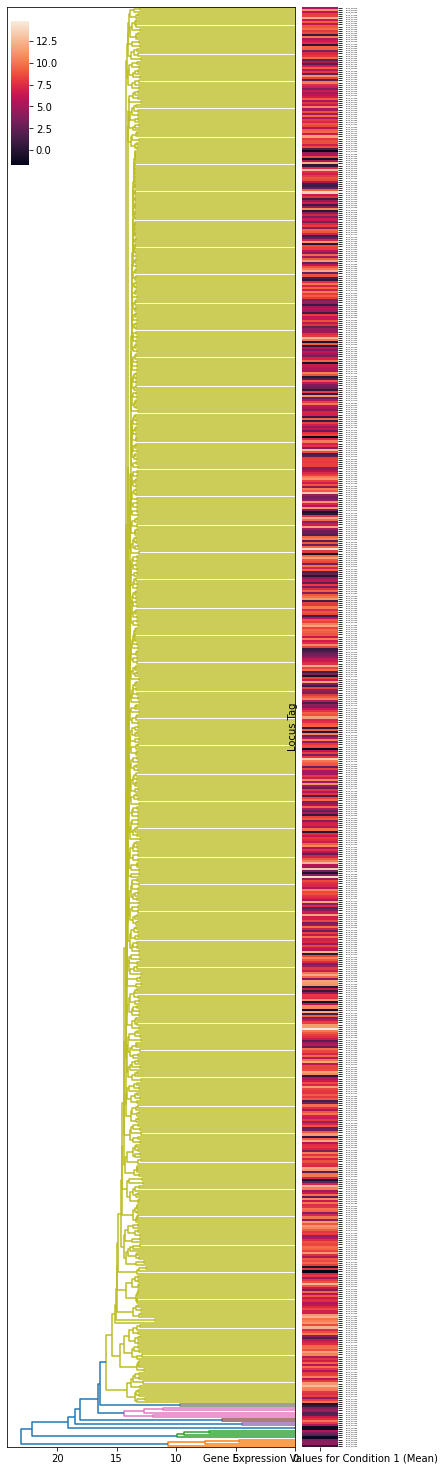

In [16]:
#Define dendogram parameters
den = plt.figure(figsize=[5, 20])
axis_1 = den.add_axes([0, 0, 0.8, 1])

#Plot dendrogram
dendrogram(average_distance, orientation="left", labels=matrix.index, leaf_font_size=1)
leaf_order = [t.get_text() for t in axis_1.get_yticklabels()]

axis_2 = den.add_axes([0.82, 0, 0.1, 1])
axis_3 = den.add_axes([0.01, 0.89, 0.05, 0.1])

#Plot the heatmap
heatmap_data = final_expression_df
heatmap_data = heatmap_data.reindex(leaf_order[::-1])

#Define heatmap parameters
sbn.heatmap(heatmap_data, yticklabels=True, ax=axis_2, cbar_ax=axis_3)
axis_2.yaxis.tick_right()
axis_2.set_yticklabels(axis_2.get_yticklabels(), rotation=0, fontsize=2)

#Save the figure
plt.savefig("dendrogram_300bp_6kmer.pdf", bbox_inches="tight")

None

## Pipeline for the Machine learning approaches
Predicting gene expression values from sequences through Extreme Gradient Boosting, Random Forest and Support Vector Machine models.

The code related to the recursive feature elimination, evaluation of the model's performance on the optimum number of features and SHAP importances was provided by Chr. Hansen.

### Definition of the training and testing set

In [13]:
#Set the model's variables
X = kmer_feature_df #features
Y = final_expression_df #target

#Split the data into training and test sets
x_train, x_test, y_train, y_test =  train_test_split(X, Y, random_state=2020)

### Extreme Gradient Boosting
Extreme Gradient Boosting (XGBoost) is an open-source machine learning library designed to improve the implementation of the gradient boosting algorithm.

In [18]:
xgb_model = xgboost.XGBRegressor(eta = 0.1)
xgb_model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination  is %.3f." % xgb_model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_model.predict(x_test), y_test).correlation)

The model's coefficient of determination  is 0.078.
The mean squared error (MSE) on test set is 9.618.
The model's Spearman correlation coefficient is 0.2543769439662483.


#### Model optimization

##### Recursive feature elimination (RFE)

In [19]:
#Identify and remove features with very low feature importance (low correlation with the target) in order to increase speed
xgb_reduced_features_1 = pd.Series(xgb_model.feature_importances_, index=x_train.columns)
xgb_reduced_features_1 = xgb_reduced_features_1[xgb_reduced_features_1 >= 0.001].index

#Recursive feature elimination
xgb_rfe = RFECV(xgboost.XGBRegressor(eta = 0.1))

#Train with reduced features
xgb_rfe.fit(x_train[xgb_reduced_features_1], y_train)

#Get ranking of features
xgb_rankings = pd.Series(xgb_rfe.ranking_, index=xgb_reduced_features_1)
xgb_reduced_features_2 = xgb_rankings[xgb_rankings == 1].index
print("The number of initial features is: %s." %len(x_train.columns))
print("The number of reduced features is: %s." %len(xgb_reduced_features_2))

#Train model on reduced features
xgb_model_rfe = xgboost.XGBRegressor(eta = 0.1)
xgb_model_rfe.fit(x_train[xgb_reduced_features_2], y_train)

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_model_rfe.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % xgb_model_rfe.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_model_rfe.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The number of initial features is: 53892.
The number of reduced features is: 138.
The model's Spearman correlation coefficient is 0.2686109202887019.
The model's coefficient of determination is 0.084.
The mean squared error (MSE) on test set is 9.552.


##### Evaluate optimum number of features for model

An input array is constant; the correlation coefficient is not defined.


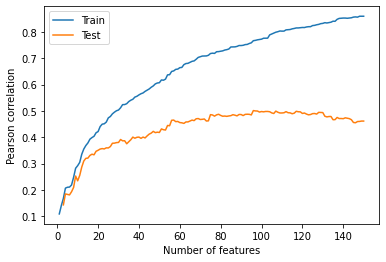

In [20]:
#Calculate performances for the training set
train_performances = []


for i in range(150):
    model_train = xgboost.XGBRegressor(eta = 0.1)
    x_train_subset = x_train[xgb_rankings.sort_values()[:i+1].index]
    model_train.fit(x_train_subset, y_train)
    train_model_feature_rank = model_train.predict(x_train_subset)
    train_performances.append(stats.pearsonr(train_model_feature_rank, y_train)[0])


#Calculate performances for the testing set
test_performances = []

splitter = KFold(5, shuffle=True, random_state=2020)

for train_index, test_index in splitter.split(x_train, y_train):
    k_performances = []
    X_train_train, X_train_test = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]

    for i in range(150):
        model_test = xgboost.XGBRegressor(eta = 0.1)
        model_test.fit(X_train_train[xgb_rankings.sort_values()[:i+1].index], y_train_train)
        test_model_feature_rank = model_test.predict(X_train_test[xgb_rankings.sort_values()[:i+1].index])
        k_performances.append(stats.pearsonr(test_model_feature_rank, y_train_test)[0])
    test_performances.append(k_performances)

test_performances = np.array(test_performances, dtype=object).mean(0)

#Plot the different performances
plt.plot(range(1, 151), train_performances, label="Train")
plt.plot(range(1, 151), test_performances, label="Test")
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Pearson correlation")
plt.show()

##### Hyperparameter optimization

In [47]:
xgb_model_hyp = xgboost.XGBRegressor(eta = 0.1)

xgb_hyper_param = {"n_estimators": stats.randint(150, 1000),
                   "learning_rate": stats.uniform(0.01, 0.59),
                   "subsample": stats.uniform(0.3, 0.6),
                   "max_depth": [3, 4, 5, 6, 7, 8, 9],
                   "colsample_bytree": stats.uniform(0.5, 0.4),
                   "min_child_weight": [1, 2, 3, 4]
                   }

xgb_param_tune = RandomizedSearchCV(xgb_model_hyp,
                         param_distributions = xgb_hyper_param,
                         cv = 10,
                         n_iter = 100,
                         refit = "neg_mean_squared_error",
                         scoring = ["neg_mean_squared_error","r2"],
                         error_score = 0,
                         verbose = 3,
                         n_jobs = 8,
                         random_state=2020)

xgb_param_tune.fit(x_train[xgb_reduced_features_2], y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 3/10] END colsample_bytree=0.8945107315446396, learning_rate=0.5253012480341862, max_depth=6, min_child_weight=4, n_estimators=787, subsample=0.876118417100245; neg_mean_squared_error: (test=-8.899) r2: (test=0.007) total time=   1.1s
[CV 10/10] END colsample_bytree=0.8945107315446396, learning_rate=0.5253012480341862, max_depth=6, min_child_weight=4, n_estimators=787, subsample=0.876118417100245; neg_mean_squared_error: (test=-8.054) r2: (test=0.072) total time=   0.9s
[CV 8/10] END colsample_bytree=0.5634855187444516, learning_rate=0.32298406566024945, max_depth=3, min_child_weight=3, n_estimators=927, subsample=0.8172953612759117; neg_mean_squared_error: (test=-11.344) r2: (test=0.068) total time=   0.7s
[CV 5/10] END colsample_bytree=0.5626798680037954, learning_rate=0.09312347446292503, max_depth=9, min_child_weight=2, n_estimators=710, subsample=0.6506179527446467; neg_mean_squared_error: (test=-9.183) r2: (test

[CV 8/10] END colsample_bytree=0.8945107315446396, learning_rate=0.5253012480341862, max_depth=6, min_child_weight=4, n_estimators=787, subsample=0.876118417100245; neg_mean_squared_error: (test=-11.002) r2: (test=0.096) total time=   1.3s
[CV 6/10] END colsample_bytree=0.5634855187444516, learning_rate=0.32298406566024945, max_depth=3, min_child_weight=3, n_estimators=927, subsample=0.8172953612759117; neg_mean_squared_error: (test=-7.404) r2: (test=0.221) total time=   0.8s
[CV 2/10] END colsample_bytree=0.5626798680037954, learning_rate=0.09312347446292503, max_depth=9, min_child_weight=2, n_estimators=710, subsample=0.6506179527446467; neg_mean_squared_error: (test=-7.946) r2: (test=0.186) total time=   1.2s
[CV 1/10] END colsample_bytree=0.5371241698893696, learning_rate=0.43056579480628515, max_depth=4, min_child_weight=4, n_estimators=475, subsample=0.6368561894597624; neg_mean_squared_error: (test=-9.277) r2: (test=0.075) total time=   0.5s
[CV 5/10] END colsample_bytree=0.5371

[CV 5/10] END colsample_bytree=0.8945107315446396, learning_rate=0.5253012480341862, max_depth=6, min_child_weight=4, n_estimators=787, subsample=0.876118417100245; neg_mean_squared_error: (test=-9.933) r2: (test=0.159) total time=   1.3s
[CV 2/10] END colsample_bytree=0.5634855187444516, learning_rate=0.32298406566024945, max_depth=3, min_child_weight=3, n_estimators=927, subsample=0.8172953612759117; neg_mean_squared_error: (test=-8.430) r2: (test=0.136) total time=   0.8s
[CV 10/10] END colsample_bytree=0.5634855187444516, learning_rate=0.32298406566024945, max_depth=3, min_child_weight=3, n_estimators=927, subsample=0.8172953612759117; neg_mean_squared_error: (test=-7.298) r2: (test=0.159) total time=   0.8s
[CV 7/10] END colsample_bytree=0.5626798680037954, learning_rate=0.09312347446292503, max_depth=9, min_child_weight=2, n_estimators=710, subsample=0.6506179527446467; neg_mean_squared_error: (test=-9.592) r2: (test=0.139) total time=   1.2s
[CV 7/10] END colsample_bytree=0.5371

[CV 4/10] END colsample_bytree=0.7999122376771528, learning_rate=0.541131015624916, max_depth=4, min_child_weight=3, n_estimators=861, subsample=0.6956292803520843; neg_mean_squared_error: (test=-8.392) r2: (test=0.136) total time=   1.0s
[CV 3/10] END colsample_bytree=0.7648664465570245, learning_rate=0.4551576590159145, max_depth=4, min_child_weight=4, n_estimators=383, subsample=0.7336449971751711; neg_mean_squared_error: (test=-8.954) r2: (test=0.001) total time=   0.4s
[CV 9/10] END colsample_bytree=0.7648664465570245, learning_rate=0.4551576590159145, max_depth=4, min_child_weight=4, n_estimators=383, subsample=0.7336449971751711; neg_mean_squared_error: (test=-13.434) r2: (test=0.040) total time=   0.4s
[CV 6/10] END colsample_bytree=0.8415725223211501, learning_rate=0.3693209591739422, max_depth=9, min_child_weight=3, n_estimators=403, subsample=0.7937944812951379; neg_mean_squared_error: (test=-7.365) r2: (test=0.225) total time=   0.7s
[CV 4/10] END colsample_bytree=0.6708481

[CV 1/10] END colsample_bytree=0.5691370286912565, learning_rate=0.17031751521806862, max_depth=8, min_child_weight=1, n_estimators=399, subsample=0.44358822943064613; neg_mean_squared_error: (test=-7.083) r2: (test=0.294) total time=   0.6s
[CV 9/10] END colsample_bytree=0.5691370286912565, learning_rate=0.17031751521806862, max_depth=8, min_child_weight=1, n_estimators=399, subsample=0.44358822943064613; neg_mean_squared_error: (test=-6.087) r2: (test=0.565) total time=   0.6s
[CV 8/10] END colsample_bytree=0.6976573856188104, learning_rate=0.3094705119690098, max_depth=8, min_child_weight=3, n_estimators=346, subsample=0.35974907399838635; neg_mean_squared_error: (test=-11.237) r2: (test=0.076) total time=   0.3s
[CV 6/10] END colsample_bytree=0.8997396422666832, learning_rate=0.5562060659397587, max_depth=7, min_child_weight=4, n_estimators=731, subsample=0.6261440057937431; neg_mean_squared_error: (test=-8.354) r2: (test=0.121) total time=   0.8s
[CV 4/10] END colsample_bytree=0.7

[CV 3/10] END colsample_bytree=0.6708481535525168, learning_rate=0.5891843167577018, max_depth=9, min_child_weight=3, n_estimators=297, subsample=0.506464406664572; neg_mean_squared_error: (test=-8.846) r2: (test=0.013) total time=   0.4s
[CV 9/10] END colsample_bytree=0.6708481535525168, learning_rate=0.5891843167577018, max_depth=9, min_child_weight=3, n_estimators=297, subsample=0.506464406664572; neg_mean_squared_error: (test=-12.301) r2: (test=0.121) total time=   0.4s
[CV 7/10] END colsample_bytree=0.5691370286912565, learning_rate=0.17031751521806862, max_depth=8, min_child_weight=1, n_estimators=399, subsample=0.44358822943064613; neg_mean_squared_error: (test=-5.829) r2: (test=0.477) total time=   0.6s
[CV 5/10] END colsample_bytree=0.6976573856188104, learning_rate=0.3094705119690098, max_depth=8, min_child_weight=3, n_estimators=346, subsample=0.35974907399838635; neg_mean_squared_error: (test=-10.160) r2: (test=0.140) total time=   0.3s
[CV 1/10] END colsample_bytree=0.8997

[CV 7/10] END colsample_bytree=0.6708481535525168, learning_rate=0.5891843167577018, max_depth=9, min_child_weight=3, n_estimators=297, subsample=0.506464406664572; neg_mean_squared_error: (test=-12.062) r2: (test=-0.083) total time=   0.4s
[CV 5/10] END colsample_bytree=0.5691370286912565, learning_rate=0.17031751521806862, max_depth=8, min_child_weight=1, n_estimators=399, subsample=0.44358822943064613; neg_mean_squared_error: (test=-6.402) r2: (test=0.458) total time=   0.6s
[CV 3/10] END colsample_bytree=0.6976573856188104, learning_rate=0.3094705119690098, max_depth=8, min_child_weight=3, n_estimators=346, subsample=0.35974907399838635; neg_mean_squared_error: (test=-9.036) r2: (test=-0.008) total time=   0.4s
[CV 2/10] END colsample_bytree=0.8997396422666832, learning_rate=0.5562060659397587, max_depth=7, min_child_weight=4, n_estimators=731, subsample=0.6261440057937431; neg_mean_squared_error: (test=-8.668) r2: (test=0.112) total time=   0.9s
[CV 10/10] END colsample_bytree=0.8

[CV 3/10] END colsample_bytree=0.58311784672382, learning_rate=0.15500519432842383, max_depth=6, min_child_weight=3, n_estimators=750, subsample=0.886761917745641; neg_mean_squared_error: (test=-9.098) r2: (test=-0.015) total time=   0.8s
[CV 8/10] END colsample_bytree=0.58311784672382, learning_rate=0.15500519432842383, max_depth=6, min_child_weight=3, n_estimators=750, subsample=0.886761917745641; neg_mean_squared_error: (test=-11.327) r2: (test=0.069) total time=   0.8s
[CV 9/10] END colsample_bytree=0.5064245378844664, learning_rate=0.38765362335610815, max_depth=3, min_child_weight=3, n_estimators=415, subsample=0.805423345930236; neg_mean_squared_error: (test=-12.527) r2: (test=0.104) total time=   0.3s
[CV 8/10] END colsample_bytree=0.5271240410122124, learning_rate=0.19301481982249452, max_depth=4, min_child_weight=2, n_estimators=667, subsample=0.6283716863991182; neg_mean_squared_error: (test=-8.941) r2: (test=0.265) total time=   0.5s
[CV 2/10] END colsample_bytree=0.8363526

[CV 2/10] END colsample_bytree=0.5271240410122124, learning_rate=0.19301481982249452, max_depth=4, min_child_weight=2, n_estimators=667, subsample=0.6283716863991182; neg_mean_squared_error: (test=-7.922) r2: (test=0.188) total time=   0.6s
[CV 9/10] END colsample_bytree=0.5271240410122124, learning_rate=0.19301481982249452, max_depth=4, min_child_weight=2, n_estimators=667, subsample=0.6283716863991182; neg_mean_squared_error: (test=-10.387) r2: (test=0.257) total time=   0.6s
[CV 7/10] END colsample_bytree=0.8363526692127954, learning_rate=0.525806347641113, max_depth=6, min_child_weight=1, n_estimators=650, subsample=0.738220210364585; neg_mean_squared_error: (test=-5.878) r2: (test=0.472) total time=   0.9s
[CV 7/10] END colsample_bytree=0.5383089258398458, learning_rate=0.2353685233082473, max_depth=5, min_child_weight=1, n_estimators=302, subsample=0.7003630005801753; neg_mean_squared_error: (test=-5.929) r2: (test=0.468) total time=   0.3s
[CV 5/10] END colsample_bytree=0.598036

[CV 2/10] END colsample_bytree=0.6571997555464681, learning_rate=0.2499958626063597, max_depth=8, min_child_weight=2, n_estimators=411, subsample=0.5509503100741932; neg_mean_squared_error: (test=-7.834) r2: (test=0.197) total time=   0.6s
[CV 9/10] END colsample_bytree=0.6571997555464681, learning_rate=0.2499958626063597, max_depth=8, min_child_weight=2, n_estimators=411, subsample=0.5509503100741932; neg_mean_squared_error: (test=-10.022) r2: (test=0.283) total time=   0.5s
[CV 10/10] END colsample_bytree=0.8147477013062325, learning_rate=0.5672290001854412, max_depth=5, min_child_weight=3, n_estimators=360, subsample=0.591490759291986; neg_mean_squared_error: (test=-7.168) r2: (test=0.174) total time=   0.4s
[CV 7/10] END colsample_bytree=0.5591312136118839, learning_rate=0.02026479597195811, max_depth=6, min_child_weight=1, n_estimators=304, subsample=0.314287529886019; neg_mean_squared_error: (test=-10.111) r2: (test=0.092) total time=   0.3s
[CV 4/10] END colsample_bytree=0.74027

[CV 5/10] END colsample_bytree=0.5858797381073745, learning_rate=0.5990138210678225, max_depth=6, min_child_weight=4, n_estimators=391, subsample=0.8483804141025597; neg_mean_squared_error: (test=-9.921) r2: (test=0.160) total time=   0.5s
[CV 4/10] END colsample_bytree=0.6571997555464681, learning_rate=0.2499958626063597, max_depth=8, min_child_weight=2, n_estimators=411, subsample=0.5509503100741932; neg_mean_squared_error: (test=-6.833) r2: (test=0.297) total time=   0.7s
[CV 3/10] END colsample_bytree=0.8147477013062325, learning_rate=0.5672290001854412, max_depth=5, min_child_weight=3, n_estimators=360, subsample=0.591490759291986; neg_mean_squared_error: (test=-9.211) r2: (test=-0.028) total time=   0.5s
[CV 1/10] END colsample_bytree=0.5591312136118839, learning_rate=0.02026479597195811, max_depth=6, min_child_weight=1, n_estimators=304, subsample=0.314287529886019; neg_mean_squared_error: (test=-8.681) r2: (test=0.135) total time=   0.4s
[CV 2/10] END colsample_bytree=0.7402749

RandomizedSearchCV(cv=10, error_score=0,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False, eta=0.1,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2abfa099a0>,
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2abfa0e310>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2abfa36310>},
                   random_state=2020, refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error', 'r2'], verbose=3)

In [48]:
xgb_param_tune.best_params_

{'colsample_bytree': 0.6726425350462941,
 'learning_rate': 0.1516810521645277,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 348,
 'subsample': 0.3895795541037643}

In [49]:
pd.DataFrame(xgb_param_tune.cv_results_).to_csv("xgb_param_tune_hyperparameter_opt_results.csv")

In [50]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(xgb_param_tune.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % xgb_param_tune.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, xgb_param_tune.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The model's Spearman correlation coefficient is 0.2645471953004743.
The model's coefficient of determination is -9.727.
The mean squared error (MSE) on test set is 9.727.


In [51]:
best_xgb_model = xgb_param_tune.best_estimator_
best_xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6726425350462941, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None, gamma=0,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1516810521645277,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=9,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=348, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [52]:
pickle.dump(best_xgb_model, open('model_xgb.sav', 'wb'))

In [174]:
import json

json.dump({"features": xgb_reduced_features_2.tolist()}, open("xgb_features.json", "w"))

### Random Forest Regression
Random Forest is an ensemble technique that uses multiple decision trees as a base learning models, combining multiple decision trees when determining the final output.

In [87]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train.iloc[:,0])

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_model.score(x_test, y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(rf_model.predict(x_test), y_test).correlation)

The model's coefficient of determination is -0.000.
The mean squared error (MSE) on test set is 10.434.
The model's Spearman correlation coefficient is 0.12540713566134723.


#### Model optimization

##### Recursive feature elimination (RFE)

In [88]:
#Identify and remove features with very low feature importance (low correlation with the target) in order to increase speed
rf_reduced_features_1 = pd.Series(rf_model.feature_importances_, index=x_train.columns)
rf_reduced_features_1 = rf_reduced_features_1[rf_reduced_features_1 >= 0.001].index

#Recursive feature elimination
rf_rfe = RFECV(RandomForestRegressor())

#Train with reduced features
rf_rfe.fit(x_train[rf_reduced_features_1], y_train.iloc[:,0])

#Get ranking of features
rf_rankings = pd.Series(rf_rfe.ranking_, index=rf_reduced_features_1)
rf_reduced_features_2 = rf_rankings[rf_rankings == 1].index
print("The number of initial features is: %s." % len(x_train.columns))
print("The number of reduced features is: %s." % len(rf_reduced_features_2))

#Train model on reduced features
rf_model_rfe = RandomForestRegressor()
rf_model_rfe.fit(x_train[rf_reduced_features_2], y_train.iloc[:,0])

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." % stats.spearmanr(
    rf_model_rfe.predict(x_test[rf_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_model_rfe.score(x_test[rf_reduced_features_2], y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_model_rfe.predict(x_test[rf_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The number of initial features is: 53892.
The number of reduced features is: 170.
The model's Spearman correlation coefficient is 0.15718544009078278.
The model's coefficient of determination is 0.006.
The mean squared error (MSE) on test set is 10.366.


##### Hyperparameter optimization

In [152]:
rf_model_hyp = rf_model = RandomForestRegressor()

rf_hyper_param = {"bootstrap": [True, False],
                  "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                  "max_features": ['sqrt'],
                  "min_samples_leaf": [1, 2, 4],
                  "min_samples_split": [2, 5, 10],
                  "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_param_tune = RandomizedSearchCV(rf_model_hyp,
                         param_distributions = rf_hyper_param,
                         cv = 10,
                         n_iter = 100,
                         refit = "neg_mean_squared_error",
                         scoring = ["neg_mean_squared_error","r2"],
                         error_score = 0,
                         verbose = 3,
                         n_jobs = 8,
                         random_state=2020)

rf_param_tune.fit(x_train[rf_reduced_features_2], y_train.iloc[:, 0])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 8/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-11.925) r2: (test=0.020) total time=   0.4s
[CV 6/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-5.735) r2: (test=0.396) total time=   3.2s
[CV 4/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; neg_mean_squared_error: (test=-9.612) r2: (test=0.011) total time=   1.2s
[CV 9/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; neg_mean_squared_error: (test=-13.961) r2: (test=0.002) total time=   1.2s
[CV 6/10] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; neg_mean_squar

[CV 2/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-9.565) r2: (test=0.020) total time=   0.4s
[CV 10/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-8.634) r2: (test=0.005) total time=   0.4s
[CV 8/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-7.645) r2: (test=0.372) total time=   3.2s
[CV 5/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; neg_mean_squared_error: (test=-11.652) r2: (test=0.014) total time=   1.2s
[CV 1/10] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-9.443) r2: (test=0.059) total time=   0.6s
[CV 3/1

[CV 5/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-11.632) r2: (test=0.015) total time=   0.4s
[CV 2/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-6.499) r2: (test=0.334) total time=   3.2s
[CV 10/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-5.527) r2: (test=0.363) total time=   3.2s
[CV 6/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-8.833) r2: (test=0.070) total time=   0.9s
[CV 10/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-8.402) r2: (test=0.032) total time=   0.9s
[CV 

[CV 7/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-11.521) r2: (test=-0.034) total time=   0.4s
[CV 5/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-6.844) r2: (test=0.421) total time=   3.2s
[CV 3/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; neg_mean_squared_error: (test=-9.569) r2: (test=-0.068) total time=   1.2s
[CV 8/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; neg_mean_squared_error: (test=-11.911) r2: (test=0.021) total time=   1.2s
[CV 5/10] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-10.774) r2: (test=0.088) total time=   0.6s
[C

[CV 3/10] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600; neg_mean_squared_error: (test=-9.585) r2: (test=-0.070) total time=   0.4s
[CV 3/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-6.000) r2: (test=0.330) total time=   3.1s
[CV 9/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; neg_mean_squared_error: (test=-9.722) r2: (test=0.305) total time=   3.2s
[CV 3/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-9.711) r2: (test=-0.084) total time=   1.0s
[CV 3/10] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; neg_mean_squared_error: (test=-5.860) r2: (test=0.346) total time=   1.7s
[CV

[CV 2/10] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; neg_mean_squared_error: (test=-9.297) r2: (test=0.047) total time=   0.3s
[CV 5/10] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; neg_mean_squared_error: (test=-10.760) r2: (test=0.089) total time=   0.3s
[CV 1/10] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; neg_mean_squared_error: (test=-9.956) r2: (test=0.008) total time=   0.7s
[CV 10/10] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; neg_mean_squared_error: (test=-8.715) r2: (test=-0.004) total time=   0.7s
[CV 8/10] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=800; neg_mean_squared_error: (test=-9.612) r2: (test=0.210) total time=   1.0s
[CV 6/10] E

[CV 7/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-11.261) r2: (test=-0.011) total time=   1.5s
[CV 5/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-10.866) r2: (test=0.080) total time=   2.2s
[CV 3/10] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; neg_mean_squared_error: (test=-6.704) r2: (test=0.252) total time=   0.7s
[CV 10/10] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; neg_mean_squared_error: (test=-7.523) r2: (test=0.133) total time=   0.6s
[CV 8/10] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; neg_mean_squared_error: (test=-10.767) r2: (test=0.115) total time=   0.3s
[CV 4/10]

[CV 5/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-11.927) r2: (test=-0.009) total time=   1.5s
[CV 3/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-9.581) r2: (test=-0.069) total time=   2.3s
[CV 1/10] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; neg_mean_squared_error: (test=-7.610) r2: (test=0.242) total time=   0.6s
[CV 4/10] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; neg_mean_squared_error: (test=-7.345) r2: (test=0.244) total time=   0.6s
[CV 9/10] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; neg_mean_squared_error: (test=-11.633) r2: (test=0.168) total time=   0.6s
[CV 7/10] 

[CV 7/10] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; neg_mean_squared_error: (test=-11.358) r2: (test=-0.020) total time=   1.3s
[CV 4/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-9.692) r2: (test=0.002) total time=   1.5s
[CV 2/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-9.384) r2: (test=0.038) total time=   2.3s
[CV 9/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; neg_mean_squared_error: (test=-13.672) r2: (test=0.023) total time=   2.3s
[CV 5/10] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; neg_mean_squared_error: (test=-11.914) r2: (test=-0.008) total time=   0.6s
[CV 3/10

[CV 7/10] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; neg_mean_squared_error: (test=-10.809) r2: (test=0.030) total time=   1.5s
[CV 5/10] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1400; neg_mean_squared_error: (test=-6.445) r2: (test=0.455) total time=   1.9s
[CV 3/10] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; neg_mean_squared_error: (test=-9.596) r2: (test=-0.071) total time=   1.5s
[CV 1/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; neg_mean_squared_error: (test=-9.855) r2: (test=0.018) total time=   0.8s
[CV 5/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; neg_mean_squared_error: (test=-11.673) r2: (test=0.012) total time=   0.7s
[C

[CV 8/10] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; neg_mean_squared_error: (test=-12.133) r2: (test=0.003) total time=   1.5s
[CV 8/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; neg_mean_squared_error: (test=-11.908) r2: (test=0.021) total time=   0.7s
[CV 6/10] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-9.360) r2: (test=0.015) total time=   0.6s
[CV 4/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; neg_mean_squared_error: (test=-4.681) r2: (test=0.518) total time=   1.1s
[CV 2/10] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; neg_mean_squared_error: (test=-8.846) r2: (test=0.094) total time=   1.8s
[CV 

[CV 9/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1200; neg_mean_squared_error: (test=-13.954) r2: (test=0.002) total time=   0.7s
[CV 7/10] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; neg_mean_squared_error: (test=-11.474) r2: (test=-0.030) total time=   0.6s
[CV 5/10] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; neg_mean_squared_error: (test=-6.970) r2: (test=0.410) total time=   1.1s
[CV 3/10] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; neg_mean_squared_error: (test=-8.313) r2: (test=0.072) total time=   1.9s
[CV 2/10] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1600; neg_mean_squared_error: (test=-9.097) r2: (test=0.068) total time=   1.7s
[CV

RandomizedSearchCV(cv=10, error_score=0, estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=2020, refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error', 'r2'], verbose=3)

[CV 7/10] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; neg_mean_squared_error: (test=-11.810) r2: (test=-0.060) total time=   0.9s
[CV 5/10] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; neg_mean_squared_error: (test=-11.657) r2: (test=0.013) total time=   1.0s
[CV 3/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; neg_mean_squared_error: (test=-9.586) r2: (test=-0.070) total time=   0.2s
[CV 7/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; neg_mean_squared_error: (test=-11.498) r2: (test=-0.032) total time=   0.2s
[CV 1/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; neg_mean_squared_error: (test=-9.431) r2: (test=0.060) total time=   2.4s
[

[CV 2/10] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; neg_mean_squared_error: (test=-9.556) r2: (test=0.021) total time=   1.0s
[CV 1/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; neg_mean_squared_error: (test=-9.836) r2: (test=0.020) total time=   0.2s
[CV 5/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; neg_mean_squared_error: (test=-11.646) r2: (test=0.014) total time=   0.2s
[CV 9/10] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; neg_mean_squared_error: (test=-13.942) r2: (test=0.003) total time=   0.2s
[CV 5/10] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; neg_mean_squared_error: (test=-10.830) r2: (test=0.083) total time=   2.3s
[CV 

In [153]:
rf_param_tune.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [154]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(rf_param_tune.predict(x_test[rf_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % rf_param_tune.score(x_test[rf_reduced_features_2], y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_param_tune.predict(x_test[rf_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The model's Spearman correlation coefficient is 0.1909144203073011.
The model's coefficient of determination is -10.248.
The mean squared error (MSE) on test set is 10.248.


In [155]:
best_rf_model = rf_param_tune.best_estimator_
best_rf_model

RandomForestRegressor(max_depth=100, max_features='sqrt', min_samples_split=10,
                      n_estimators=1400)

In [156]:
pickle.dump(best_rf_model, open('model_rf.sav', 'wb'))

In [157]:
pd.DataFrame(rf_param_tune.cv_results_).to_csv("rf_param_tune_hyperparameter_opt_results.csv")

### Support Vector Regression
Support Vector Regression is a supervised learning algorithm that is used to predict discrete values and is based on the Support Vector Machine principle.
Due to the running time of RFECV, this function was not applied to this model. Instead, we applied the features selected by the previous model with the best performance (XGBoost).

In [14]:
initial_svr_model = SVR()
initial_svr_model.fit(x_train, y_train.iloc[:,0])

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % initial_svr_model.score(x_test, y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, initial_svr_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(initial_svr_model.predict(x_test), y_test).correlation)

The model's coefficient of determination is 0.008.
The mean squared error (MSE) on test set is 10.345.
The model's Spearman correlation coefficient is 0.17170762265440356.


#### Model optimization

##### Feature selection with XGBoost reduced features

In [126]:
svr_model = SVR()
svr_model.fit(x_train[xgb_reduced_features_2], y_train.iloc[:, 0])

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % svr_model.score(x_test[xgb_reduced_features_2], y_test.iloc[:, 0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, svr_model.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(svr_model.predict(x_test[xgb_reduced_features_2]), y_test.iloc[:, 0]).correlation)

The model's coefficient of determination is 0.036.
The mean squared error (MSE) on test set is 10.055.
The model's Spearman correlation coefficient is 0.15586053853963772.


##### Hyperparameter optimization

In [127]:
svr_model_hyp = SVR()

svr_hyper_param = {"C": [0.1, 1, 10, 100, 1000],
                   "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
                   "kernel": ["rbf"]}

svr_param_tune = RandomizedSearchCV(svr_model_hyp,
                         param_distributions = svr_hyper_param,
                         cv = 10,
                         n_iter = 100,
                         refit = "neg_mean_squared_error",
                         scoring = ["neg_mean_squared_error","r2"],
                         error_score = 0,
                         verbose = 3,
                         n_jobs = 8,
                         random_state=2020)

svr_param_tune.fit(x_train[xgb_reduced_features_2], y_train.iloc[:, 0])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(cv=10, error_score=0, estimator=SVR(), n_iter=100, n_jobs=8,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   random_state=2020, refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error', 'r2'], verbose=3)

In [128]:
svr_param_tune.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 100}

In [129]:
pd.DataFrame(svr_param_tune.cv_results_).to_csv("svr_param_tune_hyperparameter_opt_results.csv")

In [130]:
#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(svr_param_tune.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % svr_param_tune.score(x_test[xgb_reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, svr_param_tune.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The model's Spearman correlation coefficient is 0.2623119838778063.
The model's coefficient of determination is -9.774.
The mean squared error (MSE) on test set is 9.774.


In [131]:
best_svr_model = svr_param_tune.best_estimator_
best_svr_model

SVR(C=100, gamma=0.01)

In [132]:
pickle.dump(best_svr_model, open('model_svr.sav', 'wb'))

## Linear regression
Linear regression evaluates the relationship between two variables by fitting a linear equation to observed data.
Due to the running time of RFECV, this function was not applied to this model. Instead, we applied the features selected by the previous model with the best performance (XGBoost).

In [141]:
lr_model_all_features = LinearRegression()
lr_model_all_features.fit(x_train, y_train.iloc[:,0])

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % lr_model_all_features.score(x_test, y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, lr_model_all_features.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(lr_model_all_features.predict(x_test), y_test).correlation)

The model's coefficient of determination is 0.076.
The mean squared error (MSE) on test set is 9.642.
The model's Spearman correlation coefficient is 0.13800734645063925.


### Model Optimization

#### Feature selection with XGBoost reduced features

In [140]:
lr_model = LinearRegression()
lr_model.fit(x_train[xgb_reduced_features_2], y_train.iloc[:,0])

#Calculate Coefficient of Determination (R-squared)
print("The model's coefficient of determination is %.3f." % lr_model.score(x_test[xgb_reduced_features_2], y_test.iloc[:,0]))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, lr_model.predict(x_test[xgb_reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(lr_model.predict(x_test[xgb_reduced_features_2]), y_test).correlation)

The model's coefficient of determination is -0.074.
The mean squared error (MSE) on test set is 11.201.
The model's Spearman correlation coefficient is 0.23426609965160777.


In [2]:
#Linear Regression does not have hyperparameters that can be tuned.

In [142]:
pickle.dump(lr_model, open('model_lr.sav', 'wb'))

### Predictions comparison

In [144]:
#Transforming the data for the predictons plots
pred_x_train = x_train.to_numpy()
pred_y_train = y_train.to_numpy()
pred_x_test = x_test.to_numpy()
pred_y_test = y_test.to_numpy()
xgb_x_train_feat = x_train[xgb_reduced_features_2].to_numpy()
xgb_x_test_feat = x_test[xgb_reduced_features_2].to_numpy()
rf_x_train_feat = x_train[rf_reduced_features_2].to_numpy()
rf_x_test_feat = x_test[rf_reduced_features_2].to_numpy()

#### Extreme Gradient Boosting

SpearmanrResult(correlation=0.2645471953004743, pvalue=0.0004194669341559536)


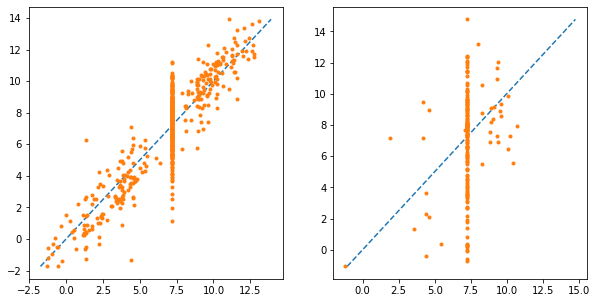

In [159]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_xgb_model.predict(xgb_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_xgb_model.predict(xgb_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_xgb_model.predict(xgb_x_test_feat), pred_y_test))

#### Random Forest Regression

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names


SpearmanrResult(correlation=0.1909144203073011, pvalue=0.011621391343574454)


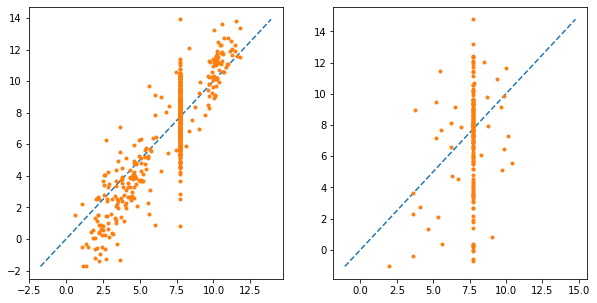

In [160]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_rf_model.predict(rf_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_rf_model.predict(rf_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_rf_model.predict(rf_x_test_feat), pred_y_test))

#### Support Vector Regression

SpearmanrResult(correlation=0.2623119838778063, pvalue=0.00047118396151199314)


X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names
X does not have valid feature names, but SVR was fitted with feature names


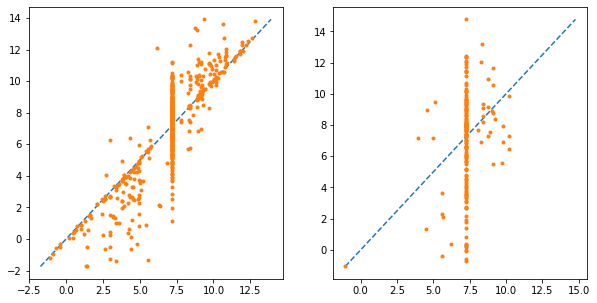

In [161]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(best_svr_model.predict(xgb_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(best_svr_model.predict(xgb_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(best_svr_model.predict(xgb_x_test_feat), pred_y_test))

#### Linear Regression

X does not have valid feature names, but LinearRegression was fitted with feature names
X does not have valid feature names, but LinearRegression was fitted with feature names
X does not have valid feature names, but LinearRegression was fitted with feature names


SpearmanrResult(correlation=0.23426609965160777, pvalue=0.0018625192221534501)


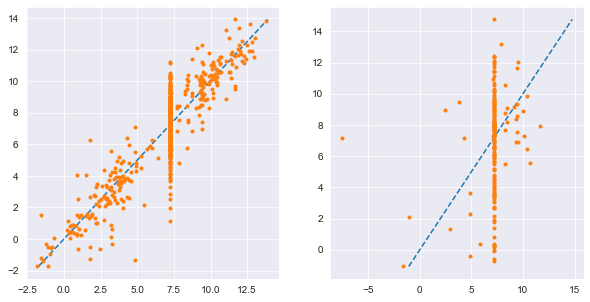

In [25]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([pred_y_train.min(), pred_y_train.max()], [pred_y_train.min(), pred_y_train.max()], "--")
plt.plot(lr_model.predict(xgb_x_train_feat), pred_y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([pred_y_test.min(), pred_y_test.max()], [pred_y_test.min(), pred_y_test.max()], "--")
plt.plot(lr_model.predict(xgb_x_test_feat), pred_y_test, ".")

print(stats.spearmanr(lr_model.predict(xgb_x_test_feat), pred_y_test))

### SHAP feature impact

#### Extreme Gradient Boosting

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


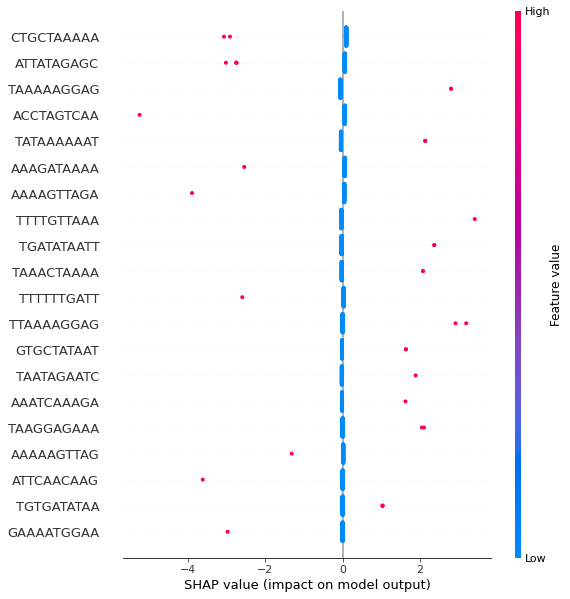

In [163]:
shap.initjs()

xgb_model_explainer = shap.TreeExplainer(best_xgb_model, x_test[xgb_reduced_features_2])
xgb_shap_values = xgb_model_explainer.shap_values(x_test[xgb_reduced_features_2])

xgb_fig = plt.figure()
xgb_ax = xgb_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(xgb_shap_values, x_test[xgb_reduced_features_2])
plt.savefig("shap_summary_xgb.pdf")
plt.close()

#### Random Forest Regression

 98%|===================| 171/174 [00:22<00:00]        

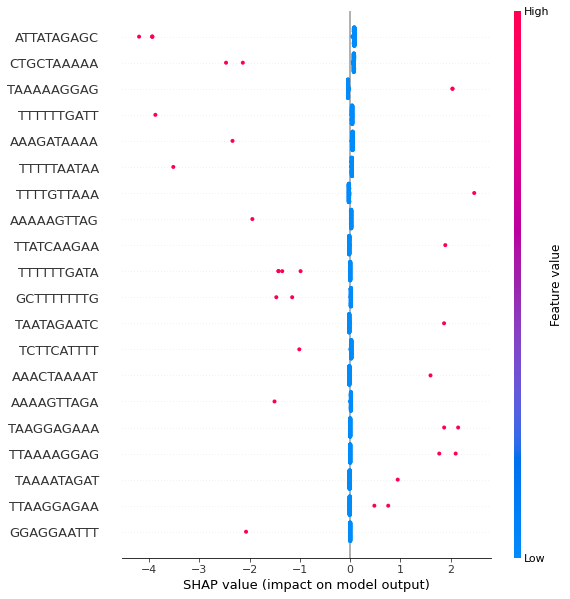

In [164]:
shap.initjs()

rf_model_explainer = shap.TreeExplainer(best_rf_model, x_test[rf_reduced_features_2])
rf_shap_values = rf_model_explainer.shap_values(x_test[rf_reduced_features_2])

rf_fig = plt.figure()
rf_ax = rf_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(rf_shap_values, x_test[rf_reduced_features_2])
plt.savefig("shap_summary_rf.pdf")
plt.close()

#### Support Vector Regression
This model is not yet supported by TreeExplainer, therefore the SHAP plots were not applied for this model.

#### Linear Regression

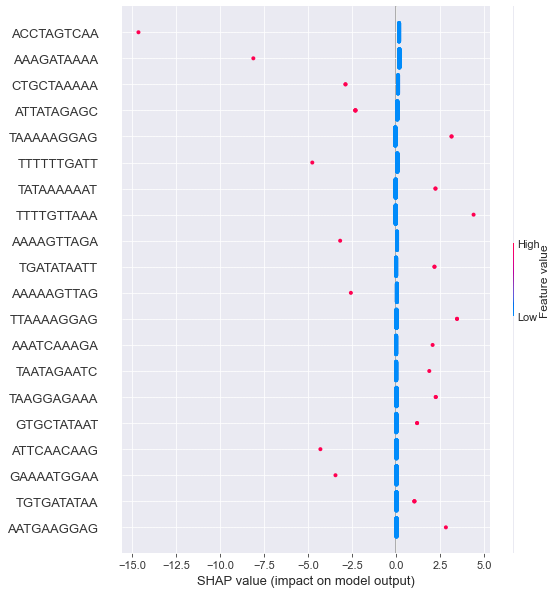

In [19]:
shap.initjs()

lr_model_explainer = shap.LinearExplainer(lr_model, x_test[xgb_reduced_features_2])
lr_shap_values = lr_model_explainer.shap_values(x_test[xgb_reduced_features_2])

lr_fig = plt.figure()
lr_ax = lr_fig.add_axes([0, 0, 0.8, 0.8])
shap.summary_plot(lr_shap_values, x_test[xgb_reduced_features_2])
plt.savefig("shap_summary_lr.pdf")
plt.close()